# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 18:34:30 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 18:34:30 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 18:34:30 - xopt.base - INFO - Running Xopt step
2025-03-02 18:34:30 - xopt.generators.deduplicated - INFO - generated 50 candidates in 2.54ms (removed 0 duplicate individuals)
2025-03-02 18:34:30 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:34:30 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.020s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 18:34:30 - xopt.base - INFO - Running Xopt step
2025-03-02 18:34:30 - xopt.generators.deduplicated - INFO - generated 50 candidates in 11.38ms (removed 0 duplicate individuals)
2025-03-02 18:34:30 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:34:30 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.023s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 18:34:30

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 812 ms
Wall time: 923 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.010384,0.971324,0.744558,0.366404,0.502934,0.724848,0.101144,0.447836,0.688388,0.086678,...,0.964917,0.940053,0.133811,0,31,0.010384,5.072450,5.310609,0.000041,False
1,0.016419,0.693081,0.379988,0.388877,0.663629,0.216669,0.052848,0.544918,0.997821,0.350164,...,0.212011,0.269536,0.055352,0,11,0.016419,4.428927,4.715269,0.000013,False
2,0.024884,0.264995,0.915759,0.657962,0.574901,0.734425,0.047922,0.376032,0.958991,0.259874,...,0.822382,0.439065,0.123413,0,33,0.024884,5.474087,5.873941,0.000010,False
3,0.047371,0.669610,0.509938,0.563154,0.743813,0.201040,0.039101,0.590520,0.364294,0.901476,...,0.584537,0.368664,0.127698,0,48,0.047371,5.231269,5.802769,0.000008,False
4,0.070835,0.941754,0.702230,0.829123,0.031223,0.353900,0.386634,0.818251,0.905176,0.375989,...,0.482825,0.823952,0.882402,0,43,0.070835,5.387529,6.101122,0.000008,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2468, 2494, 2400, 2496, 2469, 2476, 2363, 2460, 2478, 2493, 2455, 2439, 2497, 2481, 2466, 2416]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.010384,0.971324,0.744558,0.366404,0.502934,0.724848,0.101144,0.447836,0.688388,0.086678,...,0.964917,0.940053,0.133811,0,31,0.010384,5.072450,5.310609,0.000041,False
1,0.016419,0.693081,0.379988,0.388877,0.663629,0.216669,0.052848,0.544918,0.997821,0.350164,...,0.212011,0.269536,0.055352,0,11,0.016419,4.428927,4.715269,0.000013,False
2,0.024884,0.264995,0.915759,0.657962,0.574901,0.734425,0.047922,0.376032,0.958991,0.259874,...,0.822382,0.439065,0.123413,0,33,0.024884,5.474087,5.873941,0.000010,False
3,0.047371,0.669610,0.509938,0.563154,0.743813,0.201040,0.039101,0.590520,0.364294,0.901476,...,0.584537,0.368664,0.127698,0,48,0.047371,5.231269,5.802769,0.000008,False
4,0.070835,0.941754,0.702230,0.829123,0.031223,0.353900,0.386634,0.818251,0.905176,0.375989,...,0.482825,0.823952,0.882402,0,43,0.070835,5.387529,6.101122,0.000008,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

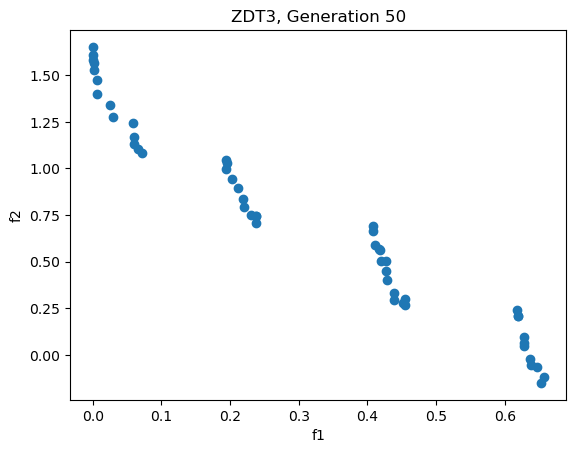

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmp0mzwcvwv"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmp0mzwcvwv": ['checkpoints', 'data.csv', 'populations.csv']
"checkpoints": ['20250302_183432_1.txt', '20250302_183432_2.txt', '20250302_183432_3.txt', '20250302_183433_1.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

Requested path: "C:\Users\chris\AppData\Local\Temp\tmp0mzwcvwv"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmp0mzwcvwv_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.007581,0.499330,0.023264,0.161447,0.181713,0.271001,0.717992,0.924693,0.915226,0.768267,...,0.806037,0.511222,0.217335,0,10,0.007581,5.288561,5.494436,0.000039,False
1,0.019613,0.728020,0.612899,0.414783,0.862595,0.699644,0.793149,0.073852,0.389696,0.989932,...,0.560272,0.781648,0.123268,0,43,0.019613,5.473926,5.823213,0.000010,False
2,0.035791,0.140044,0.716438,0.347965,0.882909,0.046178,0.888053,0.502386,0.489222,0.441431,...,0.320408,0.284239,0.805651,0,8,0.035791,5.252277,5.737725,0.000009,False
3,0.052550,0.537144,0.647099,0.601748,0.257262,0.806507,0.669344,0.070372,0.605205,0.537233,...,0.031679,0.155496,0.376742,0,41,0.052550,4.907867,5.497747,0.000008,False
4,0.083383,0.218783,0.281139,0.241711,0.225020,0.664437,0.974852,0.587134,0.095343,0.061297,...,0.044667,0.237723,0.260095,0,37,0.083383,4.309170,4.996192,0.000008,False


In [16]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.852984,0.006851,0.044621,0.263799,0.066186,0.258024,0.022633,0.107486,0.113487,0.051209,...,0.113132,0.023466,31,1589,0.852984,-0.253736,1.852567,0.000008,False,32
1551,0.000016,0.009077,0.155941,0.200829,0.217217,0.260196,0.149497,0.104698,0.035811,0.233213,...,0.048860,0.110063,31,1573,0.000016,2.084449,2.090312,0.000033,False,32
1552,0.431269,0.012105,0.021275,0.218270,0.076453,0.187651,0.019773,0.095580,0.027310,0.049242,...,0.038339,0.082545,31,1578,0.431269,0.506866,1.729156,0.000008,False,32
1553,0.409753,0.015181,0.158796,0.337596,0.077627,0.187342,0.022628,0.094794,0.027310,0.046639,...,0.014618,0.086899,31,1596,0.409753,0.825730,1.810680,0.000008,False,32
1554,0.824409,0.016124,0.160075,0.205007,0.077469,0.181814,0.154081,0.109957,0.032975,0.065753,...,0.017791,0.144218,29,1477,0.824409,0.134883,1.986673,0.000008,False,32


In [17]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [18]:
# Clean up the output directory
shutil.rmtree(output_dir)